In [1]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = WEB

train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))

test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

train, val = train_test_split(train, test_size=len(test),  
                              stratify=train['status_group'], random_state=42)

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8140409527789386


In [4]:
from sklearn.metrics import confusion_matrix;
cm = confusion_matrix(y_val, y_pred);
cm

array([[7005,  171,  622],
       [ 555,  332,  156],
       [1098,   68, 4351]])

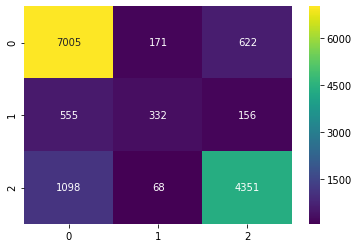

In [11]:
sns.heatmap(cm, cmap='viridis', annot=True, fmt='d')

In [16]:
columns = [f'Predicted "{c}"' for c in y_val.unique()];
columns

['Predicted "non functional"',
 'Predicted "functional"',
 'Predicted "functional needs repair"']

In [13]:
index_names = [f'Actual "{c}"' for c in y_val.unique()];
index_names

['Actual "non functional"',
 'Actual "functional"',
 'Actual "functional needs repair"']

In [17]:
df = pd.DataFrame(cm, columns=columns, index=index_names);
df.head()

,"Predicted ""non functional""","Predicted ""functional""","Predicted ""functional needs repair"""
"Actual ""non functional""",7005,171,622
"Actual ""functional""",555,332,156
"Actual ""functional needs repair""",1098,68,4351


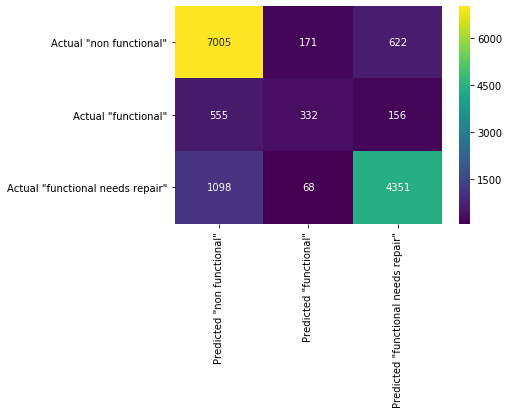

In [18]:
sns.heatmap(df, cmap='viridis', annot=True, fmt='d')

In [19]:
from sklearn.utils.multiclass import unique_labels;

In [20]:
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

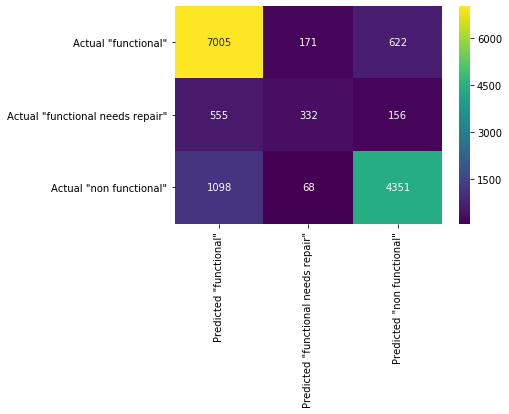

In [23]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred);
    labels = unique_labels(y_val);
    columns = [f'Predicted "{c}"' for c in labels];
    index_names = [f'Actual "{c}"' for c in labels];
    df = pd.DataFrame(cm, columns=columns, index=index_names);
    return sns.heatmap(df, cmap='viridis', annot=True, fmt='d');
plot_confusion_matrix(y_val, y_pred)

In [24]:
print(f'Total Predictions: {7005 + 332 + 4351}');

Total Predictions: 11688


In [27]:
print(f'Sum: {sum(y_val == y_pred)}');

Sum: 11688


In [28]:
print(f'Total Predictions: {len(y_val)}');

Total Predictions: 14358


In [29]:
print(f'Classification Accuracy: {(7005 + 332 + 4351) / len(y_val)}')

Classification Accuracy: 0.8140409527789386


In [30]:
from sklearn.metrics import classification_report;

In [35]:
# help(classification_report)
print(classification_report(y_val, y_pred));

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

              micro avg       0.81      0.81      0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358

